<a href="https://colab.research.google.com/github/BeardedBaldo/BasicConvnet_Pytorch/blob/main/Pytorch_NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
## import libraries

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [18]:
## check for gpus and assign to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [56]:
### load images
imageSize = (512, 512) if torch.cuda.is_available() else (128, 128)

## transform to tensor and resize image
loader = transforms.Compose([transforms.Resize(imageSize), transforms.ToTensor()])

## image loader function
def imageLoader(path):
  image = Image.open(path)
  image = loader(image).unsqueeze(0)
  return image.to(device, torch.float)

## load style and content images
contentImage = imageLoader('./images/aurora/content.jpg')
styleImage = imageLoader('./images/aurora/style.jpg')

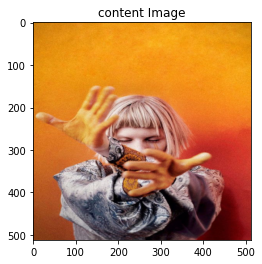

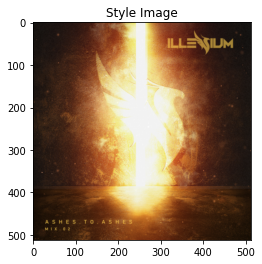

In [57]:
### display images

## transformer to PIL image
unloader = transforms.ToPILImage()

## function to display image
def imageShow(image, title = None):
  image = image.cpu().clone()
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)

plt.figure()
imageShow(contentImage, title = "content Image")

plt.figure()
imageShow(styleImage, title = "Style Image")


In [53]:
print(contentImage.size())
print(styleImage.size())

torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


In [21]:
### define content loss - read more
class contentLoss(nn.Module):
  def __init__(self, target):
    super(contentLoss, self).__init__()

    self.target = target.detach()

  def forward(self, input):
    self.loss = func.mse_loss(input, self.target)
    return input


In [22]:
### style loss - read more and understand math

## define gram matrix
def gramMatrix(input):
  a, b, c, d = input.size()

  features = input.view(a*b, c*d)

  G = torch.mm(features, features.t())

  return G.div(a * b * c * d)

## define style loss
class styleLoss(nn.Module):
  def __init__(self, target_features):
    super(styleLoss, self).__init__()
    self.target = gramMatrix(target_features).detach()

  def forward(self, input):
    G = gramMatrix(input)
    self.loss = func.mse_loss(G, self.target)
    return input


In [23]:
### import vgg19 model
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [24]:
### normalization module
cnn_NormalizationMean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_NormalizationStd = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)

  def forward(self, image):
    image = (image - self.mean)/self.std
    return image
    

In [59]:
### compute style and content losses
contentLayer_default = ['conv_1']
styleLayer_default = ['conv_1', 'conv_2', 'conv_3']

def getStyleModelLosses(cnn, normalizationMean,
                        normalizationStd, styleImage, contentImage,
                        contentLayer = contentLayer_default, 
                        styleLayer = styleLayer_default):

  cnn = copy.deepcopy(cnn)

  normalization = Normalization(normalizationMean, normalizationStd).to(device)

  contentLosses = []
  styleLosses = []

  model = nn.Sequential(normalization)
  i = 0

  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = f"conv_{i}"
    elif isinstance(layer, nn.ReLU):
      name = f"relu_{i}"
      layer = nn.ReLU(inplace = False)
    elif isinstance(layer, nn.MaxPool2d):
      name = f"pool_{i}"
    elif isinstance(layer, nn.BatchNorm2d):
      name = f"batch_{i}"
    else:
      raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")

    model.add_module(name, layer)

    if name in contentLayer:
      target = model(contentImage).detach()
      contentloss = contentLoss(target)
      model.add_module(f"content_loss_{i}", contentloss)
      contentLosses.append(contentloss)

    if name in styleLayer:
      targetFeature = model(styleImage).detach()
      styleloss = styleLoss(targetFeature)
      model.add_module(f"style_loss_{i}", styleloss)
      styleLosses.append(styleloss)

  for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], contentLoss) or isinstance(model[i], styleLoss):
      break

  model = model[:(i + 1)]

  return model, styleLosses, contentLosses


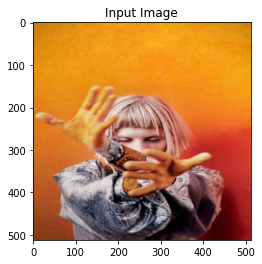

In [60]:
### create input image

inputImage = contentImage.clone()
# if you want to use white noise instead uncomment the below line:
#inputImage = torch.randn(contentImage.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imageShow(inputImage, title='Input Image')

In [61]:
## define L-BFGS optimizer
def inputOptimizer(inputImage):
  optimizer = optim.LBFGS([inputImage.requires_grad_()])
  return optimizer

In [62]:
### style transfer function

def styleTransfer(cnn, normalizationMean, normalizationStd,
                  styleImage, contentImage, inputImage, numSteps = 300,
                  styleWeight = 1000000, contentWeight = 1):
  print("Building the style transfer model")

  model, styleLosses, contentLosses = getStyleModelLosses(cnn, normalizationMean,
                                                         normalizationStd, styleImage, contentImage )
  
  optimizer = inputOptimizer(inputImage)

  print("optimizing")
  run = [0]
  while run[0] <= numSteps:
    def closure():
      inputImage.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(inputImage)
      styleScore = 0
      contentScore = 0

      for sl in styleLosses:
        styleScore += sl.loss
      for cl in contentLosses:
        contentScore += cl.loss

      styleScore *= styleWeight
      contentScore *= contentWeight

      loss = styleScore + contentScore

      loss.backward()

      run[0] += 1

      if run[0] % 50 == 0:
        print(f"run - {run}")
        print(f"style Loss - {styleScore.item()}, content loss - {contentScore.item()} \n")

      return styleScore + contentScore

    optimizer.step(closure)

  inputImage.data.clamp_(0,1)

  return inputImage
        


Building the style transfer model
optimizing


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


run - [50]
style Loss - 45.748138427734375, content loss - 0.48045891523361206 

run - [100]
style Loss - 16.511417388916016, content loss - 0.7095111012458801 

run - [150]
style Loss - 7.781900405883789, content loss - 0.7607236504554749 

run - [200]
style Loss - 3.1374597549438477, content loss - 0.8213303089141846 

run - [250]
style Loss - 1.0738099813461304, content loss - 0.8609164953231812 

run - [300]
style Loss - 0.31911948323249817, content loss - 0.8747495412826538 



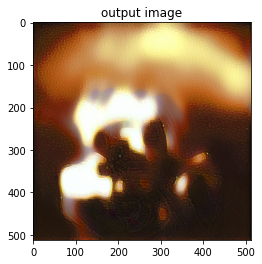

In [63]:
### run style transfer and display image

output = styleTransfer(cnn, cnn_NormalizationMean, cnn_NormalizationStd, styleImage, contentImage, inputImage)

plt.figure()
imageShow(output, title = "output image")